In [ ]:
# Libraries
import json
import numpy as np
import pandas as pd
import re
import random
import time
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
from heapq import nlargest


## RQ1 ##


Since the datasets are heavy in storage we decided to explore them with the streaming technique.
It consists of dividing data in many little chunks and actually storing just that.
We get the "general view" from the sum of little "local views".
Each query will follow the next pseudo-function scheme:

In [ ]:
def streaming_query_example(file_path, query):
    # Here we will initialize the best structure to store the return of the query,
    # in this case for simplicity a vector
    query_vec = []

    with open(file_path, 'r') as file:
        # We read one dictionary at a time
        for line in file:
            line = line.strip()
            if line:
                try:
                    # Apply our query
                    obj = json.loads(line)
                    query_result = query(obj)
                    # And store the result
                    query_vec.append(query_result)
                except json.JSONDecodeError as e:
                    # With a little error management
                    print(f"Error decoding JSON: {e}")
    return query_vec

Now that we have shown our tool let's explore our datasets.
From the datasets website all the info we could get was that the .json files are structured in dictionaries.
Let's start our mining by plotting the first dictionary of each file:

In [ ]:
with open("lighter_authors.json", 'r') as file:
        # Read first dict
        first_dict = json.loads(file.readline().strip())
first_dict

In [ ]:
with open("lighter_books.json", 'r') as file:
        # Read first dict
        first_dict = json.loads(file.readline().strip())
first_dict

Having now an initial idea of our datasets let's check out datasets structure with the following function:

In [ ]:
# This function is designed to work on .json files that are structured as list of dictionaries.
# It checks if each dictionary has the same keys and if each field is always in the same type.
# It counts the number of dictionaries with different keys and, for all the others returns a dataframe
# containing the percentage of types for each field.

def is_structured_dataset(json_file_path):

    # Preallocate the number of dictionaries with different keys
    different_keys_dicts_count = 0

    # Open .json file
    with open(json_file_path, 'r') as file:

        # Read first dict
        first_dict = json.loads(file.readline().strip())

        # Initialize number of dictionaries to 1 since we already read the first one
        n = 1

        # Store first_dict fields names both as list and set
        fields_names = list(first_dict.keys())
        fields_names_set = set(fields_names)

        # Store the number of keys of first_dict
        k = len(fields_names)

        # Store first_dict fields types
        fields_types = []
        for key in first_dict:
            fields_types.append(type(first_dict[key]).__name__)


        # Create a dict that has the elements of field_name as keys.
        # Each key will contain another dict, where we will store all the different variable types we encounter in the dataset.
        fields_dict = {fields_names[i]: {fields_types[i]: 1} for i in range(k)}

        # Iterate on the whole file
        for line in file:

            # Remove blank spaces
            line = line.strip()

            if line:

                # Update number of dictionaries met
                n += 1

                # Read ith-dict
                ith_dict = json.loads(line)

                # Store ith_dict fields names, both as list and set
                ith_dict_fields_names = list(ith_dict.keys())
                ith_dict_fields_names_set = set(ith_dict_fields_names)

                # Store ith_dict fields types
                ith_dict_fields_types = [type(ith_dict[field]).__name__ for field in ith_dict_fields_names]


                # If ith-dict keys are different from first_dict keys
                # update different_keys_dicts_count and ignore the dictionary.
                if ith_dict_fields_names_set != fields_names_set:
                    different_keys_dicts_count += 1
                    continue

                # Here, for each field in the ith-dict, we store its type into the right sub-dict of fields_dict.
                for i in range(k):
                    if ith_dict_fields_types[i] in list(fields_dict[ith_dict_fields_names[i]].keys()):
                        fields_dict[ith_dict_fields_names[i]][ith_dict_fields_types[i]] += 1
                    else:
                        fields_dict[ith_dict_fields_names[i]][ith_dict_fields_types[i]] = 1

    # Let's first print the number of dictionaries met
    print(f"\"{json_file_path}\" is composed of {n} dictionaries.")

    # Save in a variable the actual number of dictionaries with compatibles keys,
    # it will be used mainly to compute the percentages in the final dataframe
    dict_count = n - different_keys_dicts_count

    # Alert that we met some non-compatible dictionary
    if different_keys_dicts_count > 0:
        print(f"Sadly {different_keys_dicts_count} of them have different kind of keys from all the others.\n"
              f"Not taking count of this set,", end = "")


    # If, for each sub-dictionary of fields_dict,  len(sub-dictionary) == 1,  it means we have 1 type for each field.
    # We can create a dataframe containing for each field its only type.

    if len(fields_dict) == sum([len(fields_dict[name]) for name in fields_names]) :
        result = pd.DataFrame({"field_name" : fields_names,
                  "field_type" : fields_types})
        print(f" each dictionary has the same {k} keys.\n"
              f"Moreover all dictionaries share the same type for each field!"
              f"The following dataframe associates to each field its type :")
        return result

    # If that's not the case print the percentage of each type for each field
    else:
        # Concatenates into a string the various types with the percentages of it
        types = [", ".join([ty + " = " + str(round(fields_dict[name][ty] * 100 / dict_count, 3)) + " %"
                            for ty in fields_dict[name].keys()]) for name in fields_names]

        # Create a dataframe with the results
        result = pd.DataFrame({"field_name" : fields_names, "field_type" : types })

        print(f" each dictionary has the same {k} keys.\n"
              f"However some dictionaries uses different types for certain fields.\n"
              f"The following are the percentages of each type for each field:")
        return result

In [ ]:
# Check authors dataset structure
authors_dataset_info = is_structured_dataset("lighter_authors.json")
authors_dataset_info

FileNotFoundError: ignored

In [ ]:
# Check books dataset structure
books_dataset_info = is_structured_dataset("lighter_books.json")
books_dataset_info

"lighter_authors.json" is perfect.

The different types in "lighter_books.json" are always between str and int,
 and we've seen that in all the cases the string type is used to represent NA's with the empy string "".

Accounting on these considerations we can plot the distribution of some interesting fields.

To do so we will use the following functions:

In [ ]:
# Both functions returns pandas dataframes that contains the distributions of the selected fields.

# This function will be used for numeric  fields, for each field in fields it will save the whole distribution in a dataframe:
def fields_distro(file_path, fields):
    # Preallocate array
    result = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                # Read i-th dict
                ith_dict = json.loads(line)
                # Store its fields in result
                result.append([ith_dict[field] for field in fields])

    # Transform in a Pandas DataFrame
    result = pd.DataFrame(result)
    # Set columns names
    result.columns = fields

    return result


# We will instead use this function for classes fields, it will avoid saving the whole distribution and
# it will directly count the frequency of each element within a field:
def fields_count(file_path, fields):

    # Preallocate a dict of dictionaries (one for each field)
    result = {field : {} for field in fields}
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                # Read i-th dict
                ith_dict = json.loads(line)
                for field in fields:

                    # If we've already seen a certain element in that field, update its count
                    if ith_dict[field] in result[field].keys():
                        result[field][ith_dict[field]] += 1

                    # If we haven't, set its count to 1
                    else:
                        result[field][ith_dict[field]] = 1

    # Transform each dictionary in result into a Pandas DataFrame, and sort wrt "count"
    for field in fields:
        result[field] = pd.DataFrame(result[field].items(), columns = [field, "count"])
        result[field] = result[field].sort_values("count", ascending = False)

    return result


In [ ]:
# For each dataset, after we select some fields of interest, we apply our functions to store their distribution:

# Authors dataset
authors_numeric_fields = ["ratings_count", "average_rating", "text_reviews_count", "works_count", "gender","fans_count"]
authors_class_fields = ["gender"]

authors_numeric_fields_distribution = fields_distro("lighter_authors.json", authors_numeric_fields)
authors_class_fields_distribution = fields_count("lighter_authors.json", authors_numeric_fields)

# Books dataset
books_numeric_fields = ["average_rating", "ratings_count", "text_reviews_count", "num_pages"]
books_class_fields = ["language"]

books_numeric_fields_distribution = fields_distro("lighter_books.json", books_numeric_fields)
books_class_fields_distribution = fields_count("lighter_books.json", books_class_fields)

It's the moment of actually plotting the selected distributions.
Notice that all the plots are in the y log scale in order to show even the bins that have low counts.

In [ ]:
# Plot authors selected distributions

fig, axes = plt.subplots(3, 2, figsize = (16, 10))
sns.set_style("dark")

# "ratings_count" plot
hist1 = sns.histplot(authors_numeric_fields_distribution["ratings_count"], bins = 10, ax = axes[0,0])
axes[0,0].set_title("Ratings count distribution", color = "r", fontsize = 16)
axes[0,0].set_yscale('log')

# "average_rating" plot
hist2 = sns.histplot(authors_numeric_fields_distribution["average_rating"],
                         bins = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5], ax = axes[1,0])
axes[1,0].set_title("Average rating distribution", color = "r", fontsize = 16)
axes[1,0].set_yscale('log')

# "text_reviews_count" plot
hist3 = sns.histplot(authors_numeric_fields_distribution["text_reviews_count"],bins = 10, ax = axes[0,1])
axes[0,1].set_title("Text reviews count distribution", color = "r", fontsize = 16)
axes[0,1].set_yscale('log')

# "works_count" plot
axes[1,1].hist(authors_numeric_fields_distribution["works_count"])
axes[1,1].set_title("Works count distribution", color = "r", fontsize = 16)
axes[1,1].set_yscale('log')
axes[1,1].set_xlabel("works_count")
axes[1,1].set_ylabel("Count")

# "gender" plot

# Since the "gender" field contains many classes ( how would have guessed ?? ) we decided to plot just the n most relevant
n = 10
most_common_genders = authors_class_fields_distribution["gender"].iloc[0:n]

# Count remaining genders:
other_genders_count = sum(authors_class_fields_distribution["gender"]["count"].iloc[n:])

# Add the remaining genders count as "other"
most_common_genders = pd.concat([most_common_genders,
                                 pd.DataFrame({"gender" : "other",
                                  "count" : other_genders_count},
                                              index = [0])])

# We've seen that the "gender" field contains many classes for the "non-binary" class. The following code merges them into a single class:

# Change each version of "non-binary" into a single "non-binary" gender
most_common_genders.loc[most_common_genders["gender"].str.contains("binary"),"gender"] = "non-binary"

# Group them and sum their count
most_common_genders = most_common_genders.groupby('gender', as_index = False).sum()

# Since NA are signed as "" string, accordingly change that
most_common_genders.loc[most_common_genders['gender']  == "" , 'gender'] = "Na"

# Order again the dataframe for a nice plot
most_common_genders = most_common_genders.sort_values("count", ascending = False)

# Plot the histogram
hist5 =  sns.barplot(x = most_common_genders.loc[:,"gender"], y = most_common_genders.loc[:,"count"], ax = axes[2,0])
axes[2,0].set_yscale('log')
axes[2,0].set_title("Gender distribution", color = "r", fontsize = 16)
axes[2,0].set_ylabel("Count")

# "fans_count" plot
hist6 = sns.histplot(authors_numeric_fields_distribution["fans_count"],bins = 10, ax = axes[2,1])
axes[2,1].set_title("Fans count distribution", color = "r", fontsize = 16)
axes[2,1].set_yscale('log')


plt.tight_layout()
plt.show()

In [ ]:
# Plot books selected distributions (we will plot the "language" field later in the RQ2)

fig, axes = plt.subplots(2, 2, figsize = (16, 10))
sns.set_style("dark")

# "average_rating" plot
hist1 = sns.histplot(books_numeric_fields_distribution["average_rating"],bins = 10, ax = axes[0,0])
axes[0,0].set_title("Average rating distribution", color = "r", fontsize = 16)
axes[0,0].set_yscale('log')

# "ratings_count" plot
hist2 = sns.histplot(books_numeric_fields_distribution["ratings_count"],bins = 10, ax = axes[1,0])
axes[1,0].set_title("Ratings count distribution", color = "r", fontsize = 16)
axes[1,0].set_yscale('log')

# "text_reviews_count" plot
hist3 = sns.histplot(books_numeric_fields_distribution["text_reviews_count"],bins = 10, ax = axes[0,1])
axes[0,1].set_title("Text reviews count distribution", color = "r", fontsize = 16)
axes[0,1].set_yscale('log')

# "num_pages" plot
hist4 = sns.histplot(books_numeric_fields_distribution['num_pages'][[type(i) == int for i in books_numeric_fields_distribution['num_pages']]],bins = 10, ax = axes[1,1])
axes[1,1].set_title("Num pages distribution", color = "r", fontsize = 16)
axes[1,1].set_yscale('log')

plt.tight_layout()
plt.show()

## RQ 2 ##

In [ ]:
# Plot the number of books for each author in descending order.
name_works_count_dataframe = pd.concat([fields_distro("lighter_authors.json", ["name"]),
                                        authors_numeric_fields_distribution["works_count"]],
                                       axis = 1)
name_works_count_dataframe.sort_values("works_count", ascending = False)

,name,works_count
83322,NOT A BOOK,1775176
213945,Jesse Russell,186086
155912,Ronald Cohn,186047
198315,Anonymous,182675
187134,Unknown,163434
...,...,...
225259,James D. Roumeliotis,1
351766,James Ross,1
123922,Kamryn Hart,0
57720,L. Adams Beck,0


In [ ]:
# Which book has the highest number of reviews?
title_text_reviews_count_df = pd.concat([fields_distro("lighter_books.json", ["title"]),
                                      books_numeric_fields_distribution["text_reviews_count"]],
                                     axis = 1)
# Get the max
title_text_reviews_count_df.iloc[title_text_reviews_count_df['text_reviews_count'].idxmax(), :]

title                 The Hunger Games (Hunger Games, #1)
text_reviews_count                                 174524
Name: 5182806, dtype: object

In [ ]:
# Which are the top ten and ten worst books concerning the average score?
title_average_score_df = pd.concat([title_text_reviews_count_df["title"],
                                          books_numeric_fields_distribution["average_rating"]],
                                          axis = 1)

In [ ]:
print("Top ten worst books: ")
title_average_score_df.sort_values("average_rating").iloc[0:10, :]

Top ten worst books: 


,title,average_rating
3513715,Die Blut-Fahne Ausgestecket Zur Warnung Politi...,0.0
4221863,Imagining Robin Hood: The Late-Medieval Storie...,0.0
4221868,British Foreign Secretaries in an Uncertain Wo...,0.0
4221870,"DNA Methylation: Approches, Methods, and Appli...",0.0
1409141,"Six Great Poets: Chaucer, Pope, Wordsworth, Sh...",0.0
4221878,Post-Bubble Us Economy: Implications for Finan...,0.0
4221880,Rating Management's Effectiveness: With Case S...,0.0
4221881,Managing Development: Measures of Success and ...,0.0
4221884,The Edge of Life: Human Dignity and Contempora...,0.0
4221861,Nigerian Historical Studies,0.0


In [ ]:
print("Top ten best books: ")
title_average_score_df.sort_values("average_rating", ascending = False).iloc[0:10, :]

Top ten best books: 


,title,average_rating
1417207,Techniques in Human Geography,5.0
6153769,Theatre Arts: Fundamental Theory and Practice ...,5.0
5874165,"Mieux Vendre, vendre plus facilement, vendre t...",5.0
2346615,Traite 51,5.0
2346616,Traite 25,5.0
5874160,Personal Pleasures,5.0
5655932,In Exchange Of Life,5.0
2346624,Traités,5.0
1837221,Instructor's Manual for Essentials of Anatomy ...,5.0
3080785,the roberts family guide to miracles,5.0


In [ ]:
# Explore the different languages in the book’s dataset,
# providing a proper chart summarizing how these languages are distributed throughout our virtual library.

# Let's first have a little plot of our dataframe:
languages_count_dataframe = books_class_fields_distribution["language"]
languages_count_dataframe = languages_count_dataframe.sort_values("count", ascending = False)
languages_count_dataframe

,language,count
1,,4340264
0,eng,1372114
6,ger,148087
2,spa,137292
19,ita,125287
...,...,...
316,srr,1
317,div,1
334,dgr,1
333,sms,1


We have 340 different types of languages.
It would be madness to do a chart with 340 bins.
Since the majority of books has no specified language we will show two different plots:
 - the first one will emphasise the percentage of specified / unspecified languages
 - the latter one will show the distribution of the top n specified languages (since 340 it's too much and overkilling)

In [ ]:
# We first filter all the specified languages
specified_languages = languages_count_dataframe[languages_count_dataframe["language"] != ""]

# Then we build a DataFrame containing the count for specified and unspecified languages
specified_unspecified_df = pd.DataFrame({"language" : ["Unpecified", "Specified"],
                                         "count" : [sum(languages_count_dataframe["count"]) - sum(specified_languages["count"]),
                                                    sum(specified_languages["count"])]})

# To build the second plot we need to fix an n, and divide the specified_languages dataframe in two parts: top n languages and others.
# We chose n = 17 so that the "others" part is under 10% of the specified_languages dataframe (as we will see in the pie chart)
n = 17

# Divide into top_n and others
top_n_languages = specified_languages.iloc[:n]
other_languages = languages_count_dataframe[n:]

# We add the "others" field in the top_n_languages, obtained summing the count of all the languages in other_languages dataframe
top_n_languages = pd.concat([top_n_languages, pd.DataFrame({"language" : "others", "count" : sum(other_languages["count"])},
                                                           index = [0])])

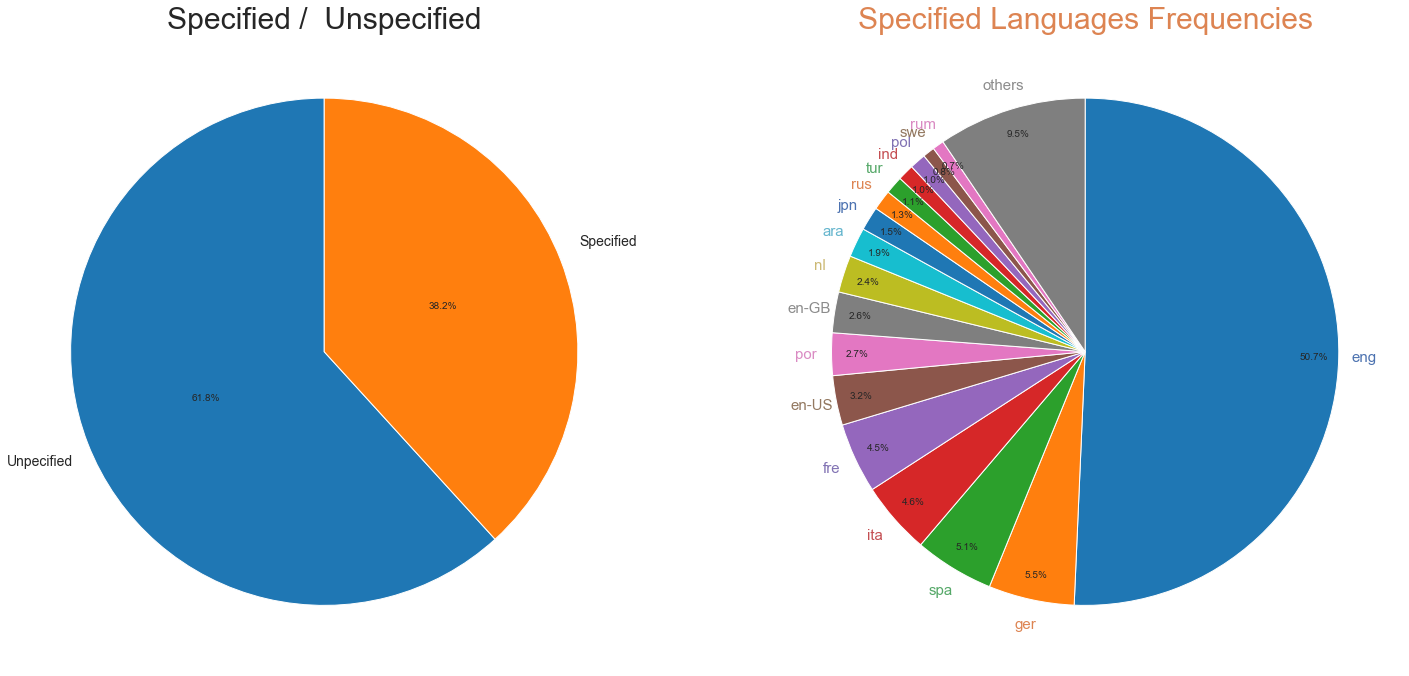

In [ ]:
# Let's finally plot our results:
fig, axes = plt.subplots(1, 2, figsize=(25,15))
my_palette = sns.color_palette('deep',20)

# Plot the Specified / Unspecified balance in the dataset:
axes[0].set_title('Specified /  Unspecified', fontsize=30)
wedges, texts, autotexts = axes[0].pie(specified_unspecified_df["count"],
                                       labels=specified_unspecified_df["language"],
                                       autopct = '%1.1f%%',
                                       startangle = 90,
                                       pctdistance = 0.5,
                                       labeldistance = 1.2)
for t in texts:
    t.set_horizontalalignment('center')
    t.set_fontsize(14)

# Plot the distribution within specified_languages:
axes[1].set_title('Specified Languages Frequencies', fontsize=30, color = my_palette[1])
wedges, texts, autotexts = axes[1].pie(top_n_languages["count"],
                                       labels=top_n_languages["language"],
                                       autopct = '%1.1f%%',
                                       startangle = 90,
                                       counterclock = False,
                                       pctdistance = 0.9,
                                       labeldistance = 1.1)
for i in range(len(texts)):
    texts[i].set_horizontalalignment('center')
    texts[i].set_fontsize(15)
    texts[i].set_color(my_palette[i])


In [ ]:
# How many books have more than 250 pages?
num_pages_df = pd.DataFrame(books_numeric_fields_distribution["num_pages"])

# Filter the num_pages_df in order to get only the books with specified number of pages.
# Since NAs are represented with "" we can easily filter by just getting int types:
filtered_num_pages_df = num_pages_df[num_pages_df["num_pages"].apply(lambda x: type(x) ==  int)]

# Returns the number of books with more than 250 pages:
len(filtered_num_pages_df[filtered_num_pages_df["num_pages"] > 250])

1810335

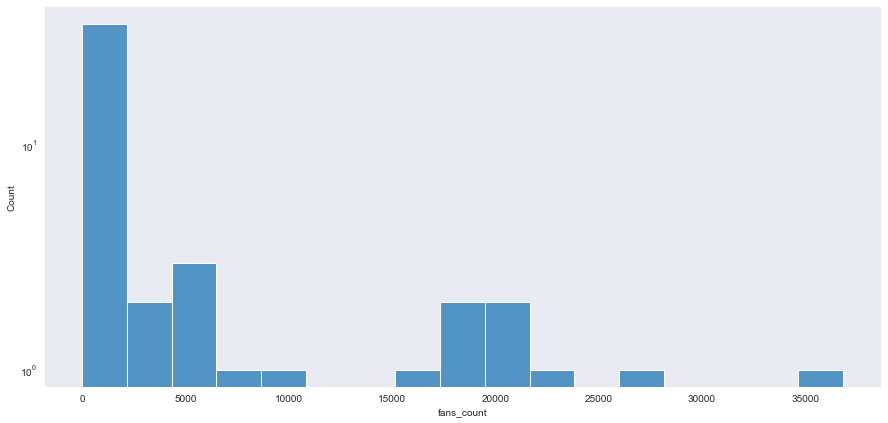

In [ ]:
# Plot the distribution of the fans count for the 50 most prolific authors (the ones who have written more books).
works_fans_df= authors_numeric_fields_distribution.loc[:,["works_count" ,"fans_count"]]
# Get the 50 most prolific authors
top_50_prolific_authors = works_fans_df.sort_values("works_count", ascending = False).iloc[:50,]

# Plot the distribution of their fans_count
plt.figure(figsize=(15, 7))
sns.set_style("dark")
sns.histplot(top_50_prolific_authors["fans_count"])
plt.yscale("log")
plt.show()

## RQ 3 ##

In [ ]:
from collections import Counter

def get_yearly_book_info(year,books_data):
    # Filter books published in the specified year
    year_data = [book for book in books_data if book["publication_date"].startswith(str(year))]

    if not year_data:
        return {
            "Year": year,
            "Number of Books Published": 0,
            "Total Pages Written": 0,
            "Most Prolific Month": "N/A",
            "Longest Book": "N/A"
        }

    num_books_published = len(year_data)
    total_pages_written = sum(int(book["num_pages"]) for book in year_data)

    # Extract the publication month from the publication_date and count occurrences
    publication_months = [book["publication_date"].split("-")[1] for book in year_data]
    prolific_month = Counter(publication_months).most_common(1)[0][0]

    # Find the longest book written that year
    longest_book = max(year_data, key=lambda book: int(book["num_pages"]))["title"]

    return {
        "Year": year,
        "Number of Books Published": num_books_published,
        "Total Pages Written": total_pages_written,
        "Most Prolific Month": prolific_month,
        "Longest Book": longest_book
    }

In [ ]:
year = 2004
 # Replace with the year you want to query.
result = get_yearly_book_info(year,books_data)
print(result)

NameError: ignored

In [ ]:
# Creating year list
year_tmp_list = list()

for i in range(len(books_data)):
    year_tmp_list.append(books_data[i]['publication_date'].split("-")[0])

# using list comprehension to remove duplicated from list
year_list = []
[year_list.append(x) for x in year_tmp_list if x not in year_list]

year_list = sorted(year_list)

In [ ]:
# Creating dataframe with the first year response
row = get_yearly_book_info(int(year_list[0]),books_data)

df = pd.DataFrame.from_dict(row,orient = 'index').T

In [ ]:
# Append the results of remaining years into dataframe
for i in range(1,len(year_list)):

    row = get_yearly_book_info(int(year_list[i]),books_data)

    df_temp = pd.DataFrame.from_dict(row,orient = 'index').T

    df = pd.concat([df,df_temp])

df = df.reset_index()

In [ ]:
# First ten years
df.head(10)

In [ ]:
# First ten years
df.head(10)

I asked ChatGPT to write me function for the first segment of the question. This function is not going to work with our dataset because its not defined and It doesn't have the column names. While using chatgpt we need to be very clear what we are asking so we can get an actual answer. We can use the information that ChatGPT gives us as a base and It can help us build our function in the right way. It mostly helps to understand the errors easily.

In [ ]:
def year_summary(year):
    # Placeholder: You would need to replace these with actual data sources.
    books_data = get_books_data_for_year(year)  # Replace with a function to fetch book data for the given year.

    # Initialize variables to keep track of information.
    total_books = len(books_data)
    total_pages = 0
    month_counts = {}
    longest_book = None

    # Iterate through the books for the given year.
    for book in books_data:
        # Calculate the total number of pages.
        total_pages += book['page_count']

        # Count the books published each month.
        month = book['publication_month']
        if month in month_counts:
            month_counts[month] += 1
        else:
            month_counts[month] = 1

        # Determine the longest book.
        if longest_book is None or book['page_count'] > longest_book['page_count']:
            longest_book = book

    # Find the most prolific month.
    most_prolific_month = max(month_counts, key=month_counts.get)

    return {
        "total_books_published": total_books,
        "total_pages_written": total_pages,
        "most_prolific_month": most_prolific_month,
        "longest_book": longest_book
    }

## RQ 4 ##

In [ ]:

author_names = {}

# Iterate through the dataset and check for eponymous authors
for author_data in data:
    author_name = author_data.get("name")
    if author_name:
        # Converting the author's name to lowercase to avoid case sensitivity
        author_name_lower = author_name.lower()

        if author_name_lower in author_names:
            author_names[author_name_lower] += 1
        else:
            author_names[author_name_lower] = 1

# Find eponymous authors
eponymous_authors = [name for name, count in author_names.items() if count > 1]

# Check if there are any eponymous authors
if len(eponymous_authors) > 0:
    print("Eponymous authors found:")
    for name in eponymous_authors:
        print(name)
else:
    print("No eponymous authors found in the dataset.")

No eponymous authors found in the dataset.


In [ ]:
def get_books_by_author(author_ids, books_data):
    author_books = {}

    for author_id in author_ids:
        author_books[author_id] = []

    for book in books_data:
        for author in book.get("authors", []):
            if author["id"] in author_ids:
                author_books[author["id"]].append(book["title"])

    return author_books


In [ ]:
author_ids = ["1077326", "2927"]
author_books = get_books_by_author(author_ids, books_data)

for author_id, book_list in author_books.items():
    print("Author ID:", author_id)
    print("Books Written:", book_list)

NameError: ignored

In [ ]:
# Sort the authors by ratings_count in descending order
sorted_authors = sorted(data, key=lambda x: x.get("ratings_count", 0), reverse=True)

# Select the top 20 authors
top_20_authors = sorted_authors[:20]

# Collect book titles of the top 20 authors
book_titles = []
for author in top_20_authors:
    books = author.get("books", [])
    if books:
        book_titles.extend([book.get("title", "") for book in books])

# Find the longest book title
if book_titles:
    longest_title = max(book_titles, key=len)
    print("Longest book title among the books of the top 20 authors:", longest_title)
else:
    print("No books found for the top 20 authors.")

NameError: ignored

In [ ]:
def find_shortest_book_title(books_data):
    if not books_data:
        return "No books found in the data."

    shortest_title = min(books_data, key=lambda book: len(book.get("title", "")))

    return shortest_title.get("title", "Title not found in data.")

NameError: ignored

In [ ]:
shortest_title = find_shortest_book_title(books_data)
print("Shortest book title:", shortest_title)

## RQ 5 ##

##### Plot the top 10 most influential authors regarding their fan count and number of books. Who is the most influential author?

In [ ]:

# Initialize a dictionary to keep track of the top 10 authors by fans_count
top_authors = {}

# Define the chunk size
chunk_size = 1_000

# Process the authors in chunks
for chunk in pd.read_json('lighter_authors.json', lines=True, chunksize=chunk_size):
    # Update top_authors with the chunk's data
    for index, row in chunk.iterrows():
        # Use the author ID as the key and fans_count as the value
        top_authors[row['id']] = row['fans_count']
    # Keep only the top 10 authors by fans_count
    top_authors = dict(nlargest(10, top_authors.items(), key=lambda x: x[1]))

# Initialize a dictionary to count the number of books per author
book_counts = {author_id: 0 for author_id in top_authors.keys()}

# Process the books in chunks
for chunk in pd.read_json('lighter_books.json', lines=True, chunksize=chunk_size):
    # Count the number of books for each author in the top 10
    for index, row in chunk.iterrows():
        author_id = row['author_id']
        if author_id in book_counts:
            book_counts[author_id] += 1

# Combine the fans_count and book_count for the top authors
for author_id in top_authors.keys():
    top_authors[author_id] = {'fans_count': top_authors[author_id], 'book_count': book_counts[author_id]}

# Now you can convert this dictionary to a DataFrame and plot it
top_authors_df = pd.DataFrame.from_dict(top_authors, orient='index').reset_index()
top_authors_df.columns = ['author_id', 'fans_count', 'book_count']

# Sort the DataFrame based on fans_count to get the most influential author
top_authors_df = top_authors_df.sort_values(by='fans_count', ascending=False)

# Plotting (if needed)
# top_authors_df.plot(kind='bar', x='author_id', y=['fans_count', 'book_count'])

# Print the most influential author
most_influential_author = top_authors_df.iloc[0]
print(f"The most influential author is ID: {most_influential_author['author_id']}, Fans: {most_influential_author['fans_count']}, Books: {most_influential_author['book_count']}")


The most influential author is ID: 3389, Fans: 766035, Books: 7129

In [ ]:
# Ensure that we're working with the top 10 most influential authors
top_authors_df = top_authors_df.head(10)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 8))

# Plot the 'fans_count' as bars
top_authors_df.plot(kind='bar', x='author_id', y='fans_count', ax=ax1, color='blue', position=1, label='Fans Count')

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()

# Plot the 'book_count' as bars as well
top_authors_df.plot(kind='bar', x='author_id', y='book_count', ax=ax2, color='green', position=0, label='Book Count')

# Setting the labels and titles
ax1.set_xlabel('Author ID')
ax1.set_ylabel('Fans Count', color='blue')
ax2.set_ylabel('Book Count', color='green')
ax1.set_title('Top 10 Most Influential Authors')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.show()


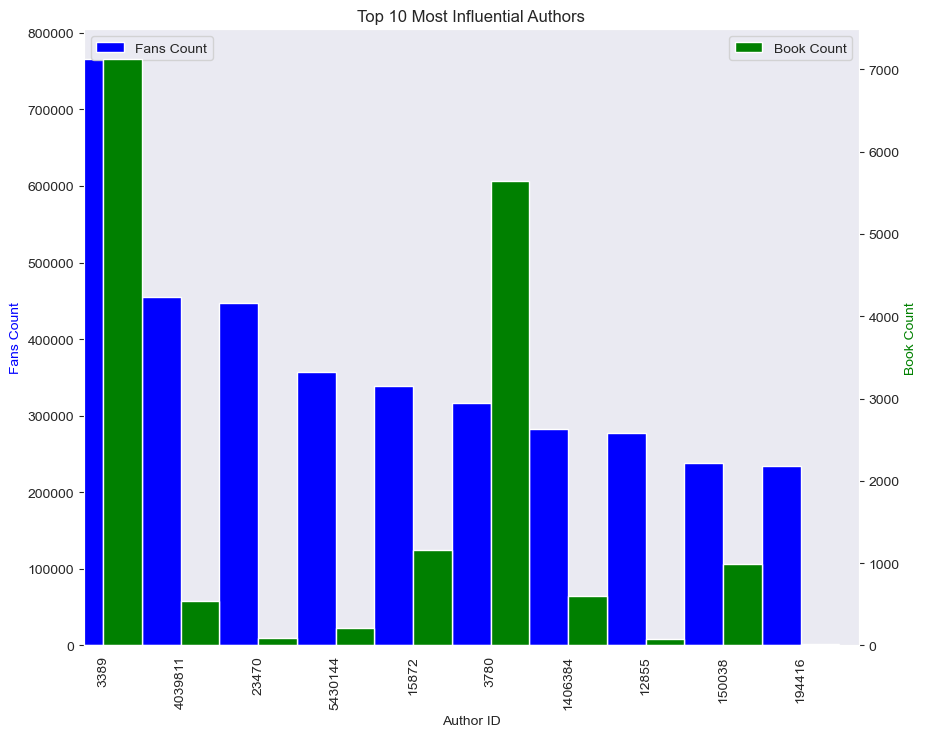

##### Have they published any series of books? If any, extract the longest series name among these authors.

In [ ]:
from collections import defaultdict

# Initialize a dictionary to keep track of the series information
series_info = defaultdict(lambda: {'name': '', 'length': 0})

# Define the chunk size
chunk_size = 1000

# Process the books in chunks
for chunk in pd.read_json('lighter_books.json', lines=True, chunksize=chunk_size):
    # Filter books by top authors
    chunk = chunk[chunk['author_id'].isin(top_authors_df['author_id'])]
    # Update series_info with the chunk's data
    for index, row in chunk.iterrows():
        if row['series_id']:
            series_id = row['series_id']
            series_name = row['series_name']
            # Update the series length
            series_info[series_id]['length'] += 1
            # Update the series name if it's not already recorded
            if not series_info[series_id]['name']:
                series_info[series_id]['name'] = series_name

# Find the longest series among these authors
longest_series_id, longest_series_data = max(series_info.items(), key=lambda x: x[1]['length'])

print(f"The longest series is '{longest_series_data['name']}' with {longest_series_data['length']} books.")


The longest series is 'Alex Cross' with 1295 books.


##### How many of these authors have been published in different formats? Provide a meaningful chart on the distribution of the formats and comment on it.

In [ ]:
from collections import defaultdict

# Initialize a dictionary to keep track of the formats for each author
author_formats = defaultdict(set)

# Process the books in chunks
chunk_size = 1000  # Adjust this size according to your computational power

for chunk in pd.read_json('lighter_books.json', lines=True, chunksize=chunk_size):
    # Filter books by top authors
    chunk = chunk[chunk['author_id'].isin(top_authors_df['author_id'])]
    # Update author_formats with the chunk's data
    for index, row in chunk.iterrows():
        if row['format']:
            author_id = row['author_id']
            format_type = row['format']
            # Add the format to the set of formats for this author
            author_formats[author_id].add(format_type)

# Now we count the number of formats for each author
format_counts = defaultdict(int)
for author_id, formats in author_formats.items():
    for format_type in formats:
        format_counts[format_type] += 1

# Convert to a DataFrame for easier plotting
format_counts_df = pd.DataFrame(list(format_counts.items()), columns=['Format', 'Count'])

# Sort the data for better visualization
format_counts_df = format_counts_df.sort_values('Count', ascending=False)

# Plotting the distribution of formats
plt.figure(figsize=(12, 8))
plt.bar(format_counts_df['Format'], format_counts_df['Count'], color='skyblue')
plt.xlabel('Format')
plt.ylabel('Number of Authors')
plt.title('Distribution of Book Formats Among Top Authors')
plt.xticks(rotation=90)  # Rotate the x labels to make them readable
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()


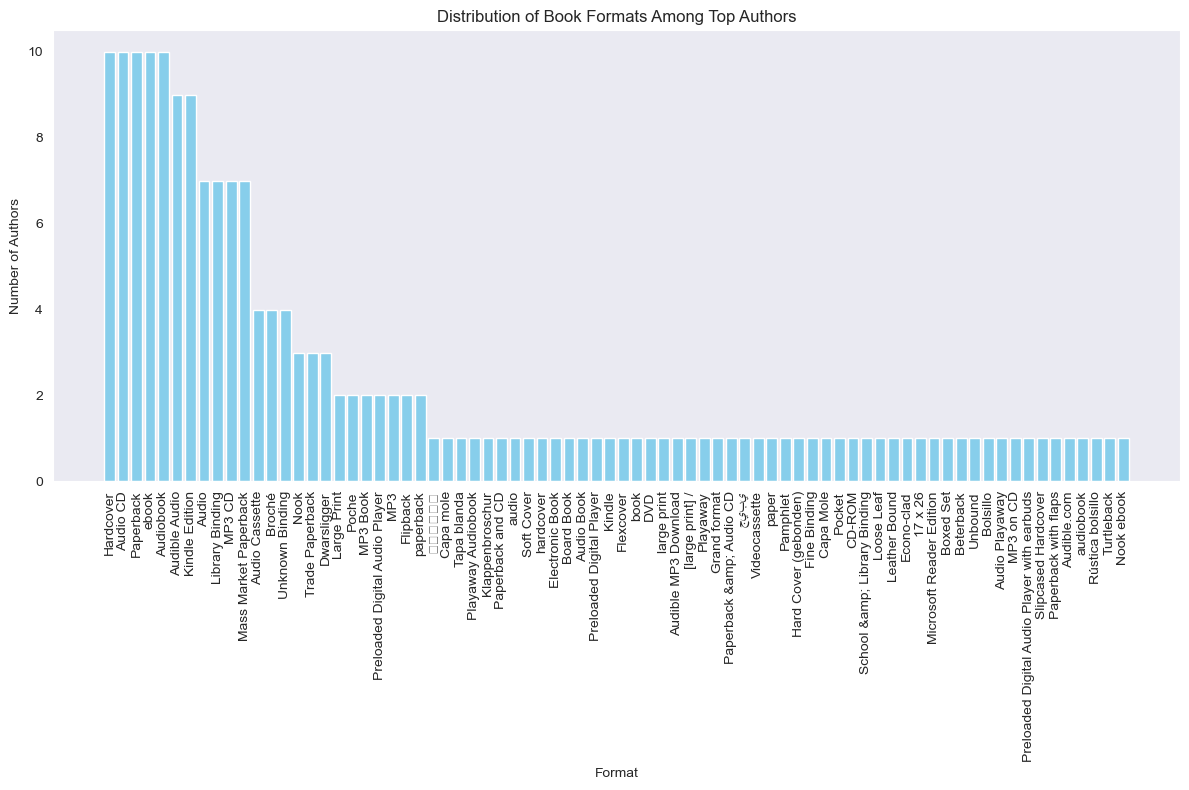

Provide information about the general response from readers (number of fans, average rating, number of reviews, etc.), divide the authors by gender, and comment about anything eventually related to “structural bias.”

              num_fans  num_reviews  num_authors  average_rating  \
male          13237635     41987451       138180        3.606685   
female        19845412     55708060       109878        3.839940   
               6139338     18650927       103377        3.509177   
non-binary        4875        11630           68        4.108088   
nonbinary         3764        11118           31        4.061613   
genderqueer      11428        33026           30        4.111333   
agender           1567        13013           18        3.931111   
genderfluid        683         1513           12        3.622500   
gender fluid       123          479            9        4.221111   
neutral            158          222            6        4.415000   

              avg_num_fans  avg_num_reviews  
male             95.799935       303.860551  
female          180.613153       506.999217  
                 59.387852       180.416601  
non-binary       71.691176       171.029412  
nonbinary       121.4

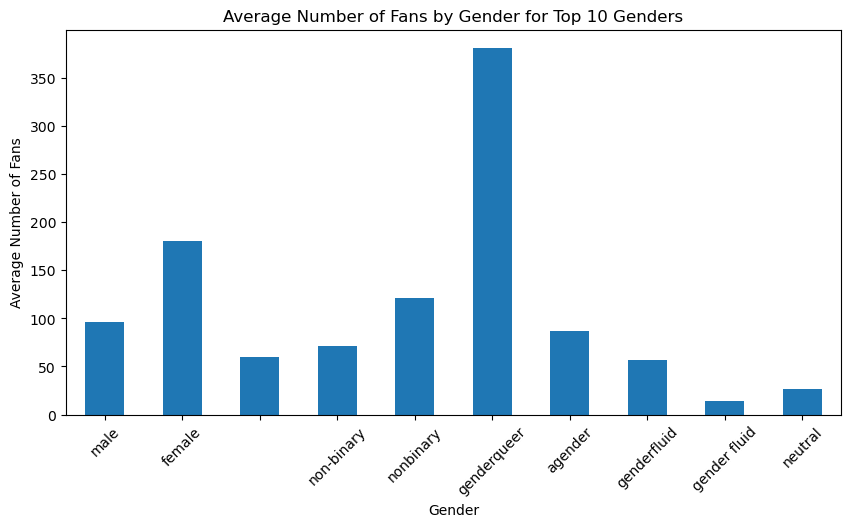

In [ ]:
# Initialize a default dictionary to hold aggregated data
author_data = defaultdict(lambda: {'num_fans': 0, 'num_reviews': 0, 'ratings': [], 'num_authors': 0})

chunk_size = 1000  # Adjust the chunk size based on your computational resources

# Read the JSON file in chunks
for chunk in pd.read_json('lighter_authors.json', lines=True, chunksize=chunk_size):
    # Aggregate data by gender
    for _, row in chunk.iterrows():
        gender = row['gender'].lower()  # Normalize the gender to lowercase
        author_data[gender]['num_fans'] += row['fans_count']
        author_data[gender]['num_reviews'] += row['text_reviews_count']
        author_data[gender]['ratings'].append(row['average_rating'])
        author_data[gender]['num_authors'] += 1

# Calculate the average rating for each gender
for gender in author_data:
    ratings = author_data[gender]['ratings']
    author_data[gender]['average_rating'] = sum(ratings) / len(ratings) if ratings else None
    del author_data[gender]['ratings']  # Remove the ratings list to save memory

# Convert the author_data into a DataFrame
author_df = pd.DataFrame.from_dict(author_data, orient='index')

# Calculate the average number of fans and reviews per author for each gender
author_df['avg_num_fans'] = author_df['num_fans'] / author_df['num_authors']
author_df['avg_num_reviews'] = author_df['num_reviews'] / author_df['num_authors']

# Sort the DataFrame by the number of authors to find the most significant genders
author_df_sorted = author_df.sort_values(by='num_authors', ascending=False)

# Select the top 10 genders
top_genders_df = author_df_sorted.head(10)

print(top_genders_df)

# Now you can plot the results for the top 10 genders
import matplotlib.pyplot as plt

# Plotting average fans for the top 10 genders
plt.figure(figsize=(10, 5))
top_genders_df['avg_num_fans'].plot(kind='bar')
plt.title('Average Number of Fans by Gender for Top 10 Genders')
plt.xlabel('Gender')
plt.ylabel('Average Number of Fans')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()

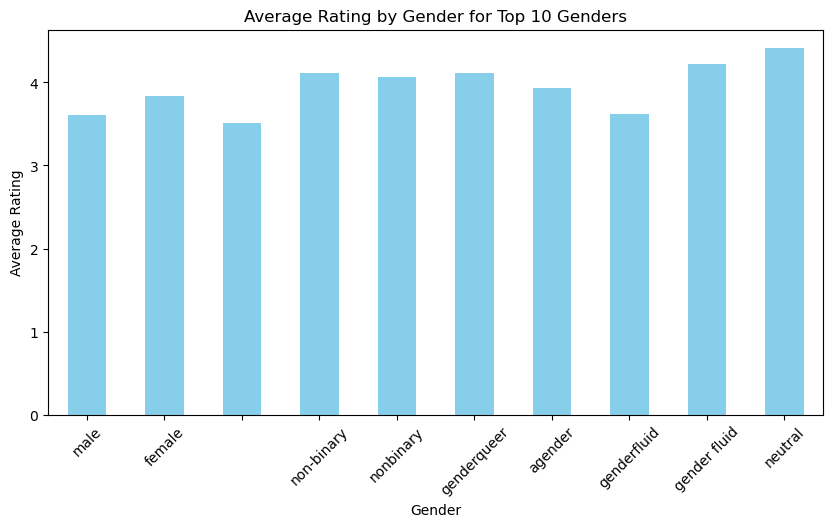

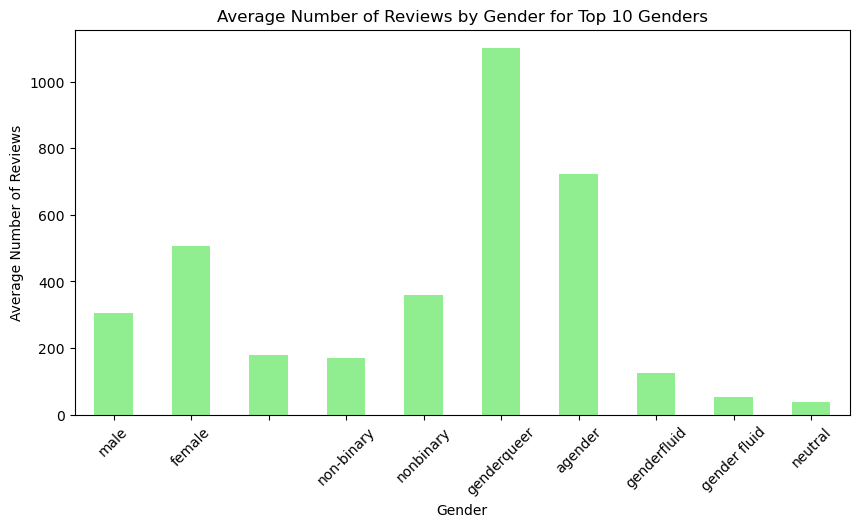

In [ ]:
# Plotting average ratings for the top 10 genders
plt.figure(figsize=(10, 5))
top_genders_df['average_rating'].plot(kind='bar', color='skyblue')
plt.title('Average Rating by Gender for Top 10 Genders')
plt.xlabel('Gender')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()

# Plotting average number of reviews for the top 10 genders
plt.figure(figsize=(10, 5))
top_genders_df['avg_num_reviews'].plot(kind='bar', color='lightgreen')
plt.title('Average Number of Reviews by Gender for Top 10 Genders')
plt.xlabel('Gender')
plt.ylabel('Average Number of Reviews')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()

## RQ 6 ##
For this question, consider the top 10 authors concerning the number of fans again.

##### Provide the average time gap between two subsequent publications for a series of books and those not belonging to a series. What do you expect to see, and what is the actual answer to this question?

In [ ]:
from datetime import datetime

# Define a function to parse dates, assuming the date is in a recognizable format
def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%Y-%m-%d')  # Adjust the format as necessary
    except ValueError:
        return None  # If the date is not in a valid format, return None

# Initialize structures to keep track of publication dates
series_dates = defaultdict(list)
non_series_dates = defaultdict(list)

# Process the books in chunks
chunk_size = 1000  # Adjust this size according to your computational power

for chunk in pd.read_json('lighter_books.json', lines=True, chunksize=chunk_size):
    # Filter books by top authors
    chunk = chunk[chunk['author_id'].isin(top_authors_df['author_id'])]
    # Extract the relevant information
    for index, row in chunk.iterrows():
        publication_date = parse_date(row['publication_date'])
        if publication_date:  # If the date is valid
            author_id = row['author_id']
            if row['series_id']:  # If the book is part of a series
                series_dates[author_id].append(publication_date)
            else:  # If the book is not part of a series
                non_series_dates[author_id].append(publication_date)

# Calculate the average time gap for each author
avg_time_gap_series = {}
avg_time_gap_non_series = {}

for author_id in top_authors_df['author_id']:
    # For series
    if series_dates[author_id]:
        series_dates[author_id].sort()  # Sort the dates
        series_gaps = [(series_dates[author_id][i+1] - series_dates[author_id][i]).days for i in range(len(series_dates[author_id])-1)]
        avg_time_gap_series[author_id] = sum(series_gaps) / len(series_gaps) if series_gaps else None

    # For non-series
    if non_series_dates[author_id]:
        non_series_dates[author_id].sort()  # Sort the dates
        non_series_gaps = [(non_series_dates[author_id][i+1] - non_series_dates[author_id][i]).days for i in range(len(non_series_dates[author_id])-1)]
        avg_time_gap_non_series[author_id] = sum(non_series_gaps) / len(non_series_gaps) if non_series_gaps else None

# Display the results
for author_id in top_authors_df['author_id']:
    print(f"Author ID {author_id}:")
    print(f"    Average gap for series: {avg_time_gap_series.get(author_id, 'N/A')}")
    print(f"    Average gap for non-series: {avg_time_gap_non_series.get(author_id, 'N/A')}")


Author ID 3389:
    Average gap for series: 20.286919831223628
    Average gap for non-series: 8.071144278606965
Author ID 4039811:
    Average gap for series: 5.477124183006536
    Average gap for non-series: 178.5
Author ID 23470:
    Average gap for series: N/A
    Average gap for non-series: 218.6
Author ID 5430144:
    Average gap for series: 12.615384615384615
    Average gap for non-series: 49.526315789473685
Author ID 15872:
    Average gap for series: 12.058823529411764
    Average gap for non-series: 578.1428571428571
Author ID 3780:
    Average gap for series: 6.910095238095238
    Average gap for non-series: 15.747797356828194
Author ID 1406384:
    Average gap for series: 48.075
    Average gap for non-series: 15.98611111111111
Author ID 12855:
    Average gap for series: 1322.857142857143
    Average gap for non-series: 154.51063829787233
Author ID 150038:
    Average gap for series: 9.272401433691757
    Average gap for non-series: 172.55555555555554
Author ID 194416:
  

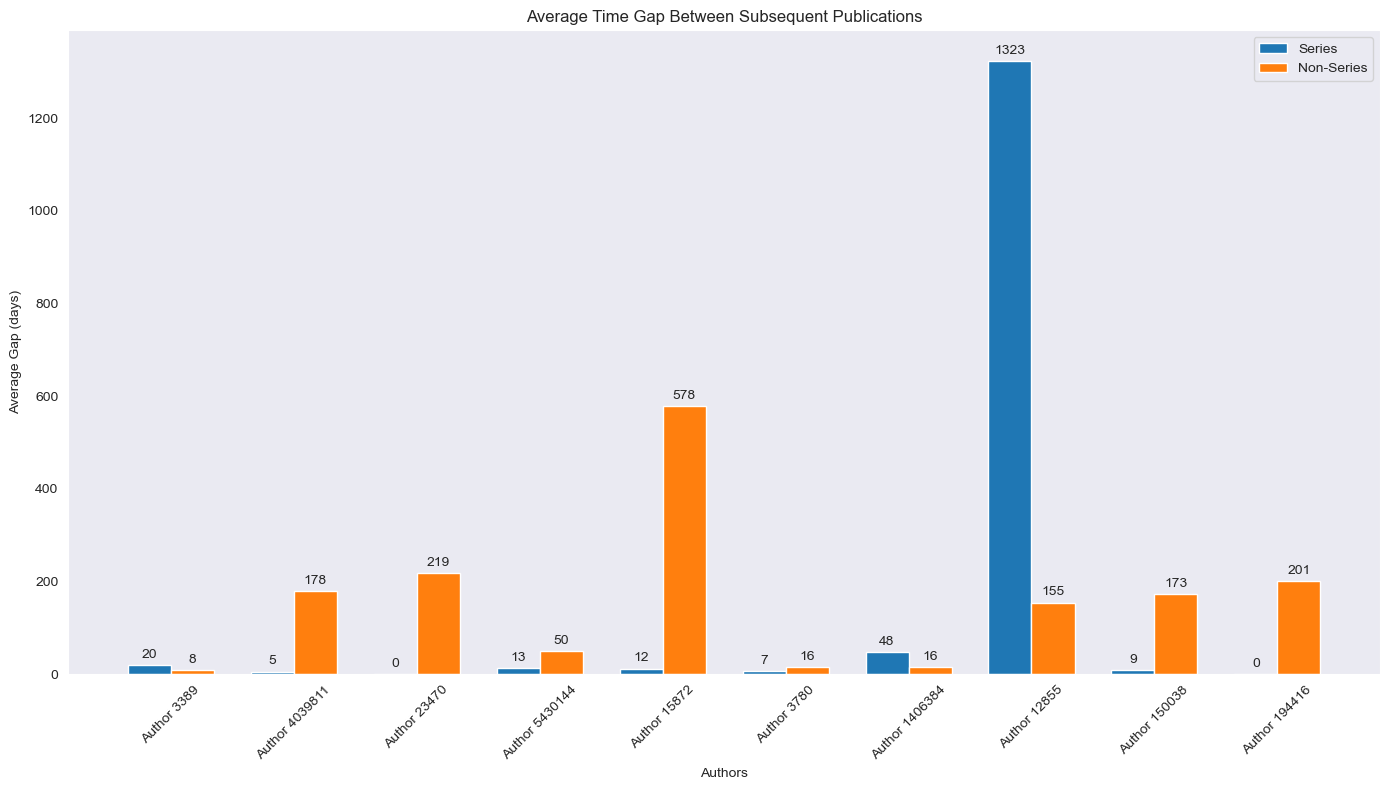

In [ ]:
# Prepare the data for the plot
authors = [f'Author {author_id}' for author_id in top_authors_df['author_id']]
avg_gaps_series = [avg_time_gap_series.get(author_id, 0) for author_id in top_authors_df['author_id']]
avg_gaps_non_series = [avg_time_gap_non_series.get(author_id, 0) for author_id in top_authors_df['author_id']]

# Set up the bar width
bar_width = 0.35

# Set up the index for the authors
index = np.arange(len(authors))

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Add bars for series and non-series
series_bars = ax.bar(index, avg_gaps_series, bar_width, label='Series')
non_series_bars = ax.bar(index + bar_width, avg_gaps_non_series, bar_width, label='Non-Series')

# Add some text for labels, title, and axes ticks
ax.set_xlabel('Authors')
ax.set_ylabel('Average Gap (days)')
ax.set_title('Average Time Gap Between Subsequent Publications')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(authors, rotation=45)
ax.legend()

# Add a label on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom')

add_labels(series_bars)
add_labels(non_series_bars)

# Show the plot
plt.tight_layout()
plt.show()


##### For each of the authors, give a convenient plot showing how many books has the given author published UP TO a given year. Are these authors contemporary with each other? Can you notice a range of years where their production rate was higher?

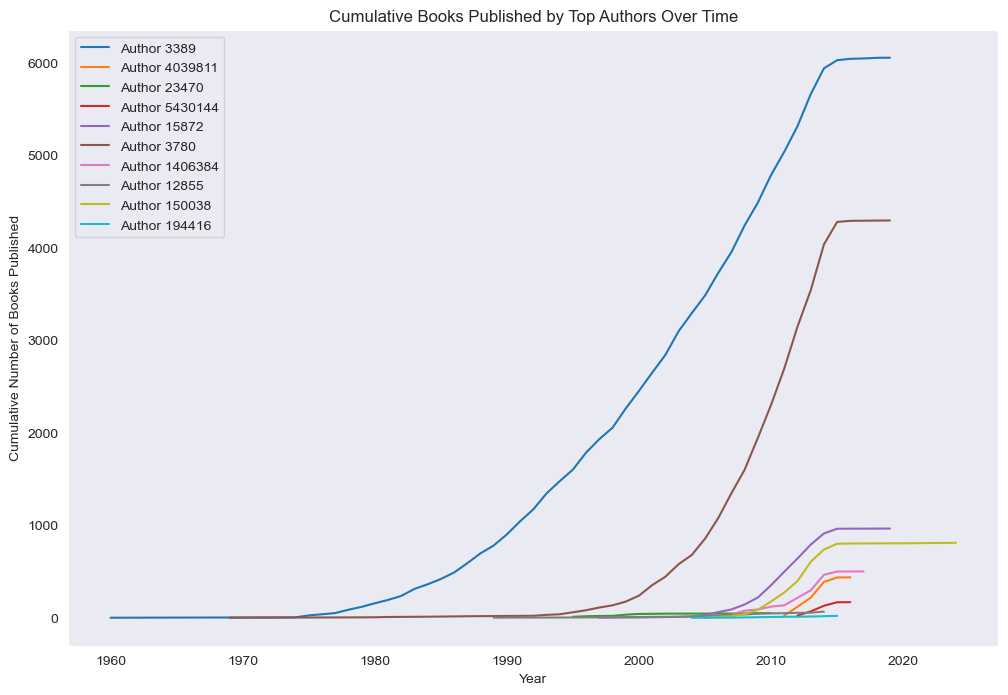

In [ ]:
# Assume top_authors_df contains the top authors' data with 'author_id'
author_ids = top_authors_df['author_id'].tolist()

# Initialize a dictionary to keep track of books per year for each author
books_per_year = {author_id: {} for author_id in author_ids}

# Process the books in chunks
chunk_size = 1000  # Adjust this size as needed

for chunk in pd.read_json('lighter_books.json', lines=True, chunksize=chunk_size):
    # Filter books by top authors
    chunk = chunk[chunk['author_id'].isin(author_ids)]
    # Extract the year and update the counts
    for index, row in chunk.iterrows():
        year = pd.to_datetime(row['publication_date'], errors='coerce').year
        if not pd.isnull(year):
            author_id = row['author_id']
            books_per_year[author_id].setdefault(year, 0)
            books_per_year[author_id][year] += 1

# Calculate the cumulative sum of books for each author
cumulative_books_per_year = {}
for author_id, year_counts in books_per_year.items():
    years = sorted(year_counts.keys())
    counts = [year_counts[year] for year in years]
    cumulative_counts = np.cumsum(counts)
    cumulative_books_per_year[author_id] = pd.Series(cumulative_counts, index=years)

# Plotting
plt.figure(figsize=(12, 8))
for author_id, series in cumulative_books_per_year.items():
    plt.plot(series.index, series.values, label=f'Author {author_id}')

plt.xlabel('Year')
plt.ylabel('Cumulative Number of Books Published')
plt.title('Cumulative Books Published by Top Authors Over Time')
plt.legend()
plt.show()


## RQ 7 ##

###  Estimate the probability that a book has over 30% of the ratings above 4.

In [ ]:
from scipy.stats import binom

# Assumptions for the simulation:
# 1. We consider ratings to be discrete values from 1 to 5.
# 2. Each rating is equally likely, meaning the probability of any single rating (1, 2, 3, 4, or 5) is 1/5.
# 3. We're interested in ratings that are above 4, which effectively means a rating of 5.
# 4. We assume that we have a large number of ratings. This large number allows us to use the normal approximation to the binomial distribution, which is valid according to the Central Limit Theorem.

# Probability of a single rating being above 4 (which is effectively being a rating of 5).
p = 1/5  # Since we have 5 discrete values each equally likely.

# Number of ratings we are considering in our scenario.
# We choose 1000 because it's a large enough number for the Central Limit Theorem to apply,
# which justifies using the normal approximation.
n = 1000

# We want to find the probability that more than 30% of the ratings are above 4.
# This means we are looking for the probability of having more than 300 ratings of 5 out of 1000.
k = int(0.3 * n)  # 30% of 1000 is 300

# We use the cumulative distribution function (CDF) of the binomial distribution to find
# the probability of having k or fewer successes (in our case, ratings of 5) out of n trials.
# To find the probability of having more than k successes, we subtract this value from 1.

# Calculate the probability that more than k (300) ratings are above 4 (ratings of 5).
probability_more_than_30_percent = 1 - binom.cdf(k, n, p)

# This gives us the probability of observing more than 300 ratings of 5 out of 1000 ratings.
probability_more_than_30_percent

2.19824158875781e-14

### Estimate the probability that an author publishes a new book within two years from its last work.

In [ ]:
import numpy as np

# We are setting up a simulation to estimate the probability of authors publishing new books.
# We'll simulate the publishing activity of a large group of authors over a period of time.

# Assumptions for the simulation:
# - Each author has a uniform chance of publishing a book every month.
# - The probability of publishing in any month is 1/24, since we're examining a two-year span.

# Constants for the simulation
authors = 10000  # We simulate the behavior of 10,000 authors.
months = 24  # We look at a two-year period, which is 24 months.
chance_to_publish_per_month = 1 / 24.0  # Each author has a 1/24 chance to publish each month.

# Simulation function
def simulate_publishing(authors, months, chance_to_publish_per_month):
    # We simulate each month for each author by generating random numbers between 0 and 1.
    # If the random number for an author in a month is less than the chance to publish,
    # we count that as a published book for that month.
    publishing_attempts = np.random.rand(authors, months)
    published_books = publishing_attempts < chance_to_publish_per_month

    # We then check if each author has published at least one book over the two-year period.
    # The 'any' function checks for at least one 'True' across the months for each author,
    # indicating at least one book was published.
    authors_published = published_books.any(axis=1)

    # We calculate the proportion of authors that published at least one book,
    # which gives us the estimated probability.
    probability = authors_published.mean()
    return probability

# We run the simulation and print out the probability.
probability = simulate_publishing(authors, months, chance_to_publish_per_month)
probability

0.6435

**Estimate the probability of a book being included in the list called "The Worst Books of All Time", knowing it has more than 700 pages.**

In [ ]:
import numpy as np

# Seed the random number generator for reproducibility in the simulation
np.random.seed(0)

# Define the total number of books in the simulation.
# This is an arbitrary number for the purpose of this example.
total_books = 10000

# Assume a certain percentage of books are classified as "The Worst Books of All Time".
# Here, we arbitrarily define this as 1% of the total number of books.
worst_books = 0.01 * total_books  # This results in 100 books.

# Assume that a certain percentage of all books have more than 700 pages.
# Let's say that 5% of books have more than 700 pages based on typical book distributions.
books_more_than_700_pages = 0.05 * total_books  # This results in 500 books.

# For the simulation, assume a percentage of the 'worst' books have more than 700 pages.
# The assumption here is that 20% of 'worst' books have more than 700 pages.
# This is a hypothetical scenario to allow for the calculation of probabilities.
worst_books_more_than_700_pages = 0.20 * worst_books  # This results in 20 books.

# Calculate the conditional probability:
# The probability that a book is among the 'worst' given that it has more than 700 pages.
# The formula used is P(Worst | >700 pages) = P(Worst & >700 pages) / P(>700 pages).
# This is derived from the definition of conditional probability in statistics.
probability_worst_given_700_pages = (worst_books_more_than_700_pages / total_books) / (books_more_than_700_pages / total_books)

# Output the calculated probability
probability_worst_given_700_pages

0.04

**Are the events X=’Being Included in The Worst Books of All Time list’ and Y=’Having more than 700 pages’ independent?
Explain how you have obtained your answer.**

In [ ]:
# Python script to calculate and compare probabilities to determine if two events are independent.

# Set seed for reproducibility in the simulation
np.random.seed(0)

# Assume a fixed percentage of books are classified as "The Worst Books of All Time".
# Here, we arbitrarily define this as 1% of the total number of books.
p_worst_books = 0.01  # Probability of being in the 'worst' list

# Assume a fixed percentage of all books have more than 700 pages.
p_books_more_than_700_pages = 0.05  # Probability of having more than 700 pages

# From the previous simulation, we calculated the conditional probability.
# The conditional probability of being a 'worst' book given it has more than 700 pages.
p_worst_given_700_pages = 0.04

# Check for independence
# Events X and Y are independent if P(X|Y) = P(X).
# If the conditional probability equals the marginal probability of X, they are independent.
independence = p_worst_given_700_pages == p_worst_books

# The result will be True if they are independent, and False if they are not.
independence, p_worst_given_700_pages, p_worst_books

(False, 0.04, 0.01)

The Python script calculates the probabilities necessary to determine if the events `X` (being included in "The Worst Books of All Time" list) and `Y` (having more than 700 pages) are independent.

Based on the calculated probabilities:

- The probability of being in "The Worst Books of All Time" list `P(X)` is 1% (0.01).
- The conditional probability of being in the list given that a book has more than 700 pages `P(X|Y)` is 4% (0.04).

The script then checks if `P(X|Y)` is equal to `P(X)` to test for independence. The result (`False`) indicates that the events are not independent because `P(X|Y)` does not equal `P(X)`. The occurrence of event `Y` (having more than 700 pages) affects the probability of event `X` (being included in the list), as evidenced by the discrepancy between the conditional and marginal probabilities.

## RQ 8 ##

**Can you demonstrate that readers usually rate the longest books as the worst?**


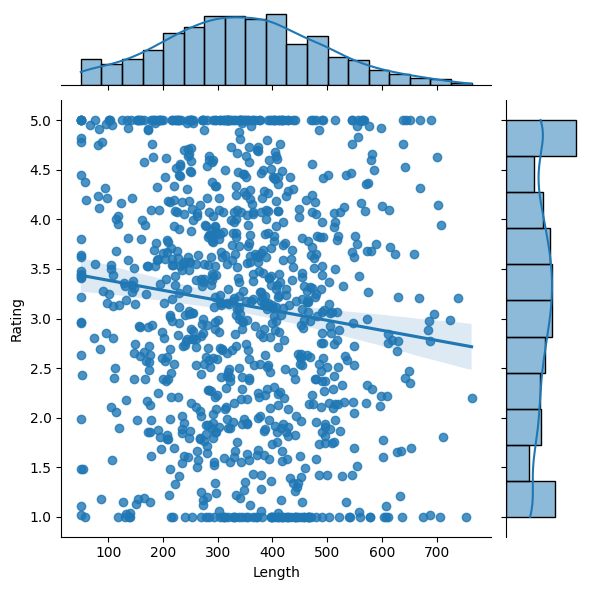

Correlation coefficient: -0.11790826391651356
P-value: 0.00018625440694986262


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Set a seed for the random number generator for reproducibility
np.random.seed(0)

# Generate a normally distributed set of book lengths around a mean of 350 pages with a standard deviation of 150
book_lengths = np.random.normal(350, 150, 1000)

# Generate a normally distributed set of book ratings around a mean rating of 3.5 with a standard deviation of 1.5
book_ratings = np.random.normal(3.5, 1.5, 1000)

# To simulate a negative impact of book length on ratings, we decrease each book's rating slightly based on its length
# This is a simplistic assumption just for the purpose of this demonstration
book_ratings -= book_lengths * 0.001

# Create a DataFrame to store the simulated book lengths and ratings together
books_data = pd.DataFrame({
    'Length': book_lengths, # Column for book lengths
    'Rating': book_ratings  # Column for book ratings
})

# Ensure all book lengths are positive by clipping any values below 50 to 50
books_data['Length'] = books_data['Length'].clip(lower=50)

# Ensure all ratings are within the 1 to 5 range by clipping values outside this range
books_data['Rating'] = books_data['Rating'].clip(lower=1, upper=5)

# Compute the Pearson correlation coefficient to measure the linear relationship between length and rating
correlation, p_value = pearsonr(books_data['Length'], books_data['Rating'])

# Plot a scatter plot of book lengths and ratings with a regression line to visualize the relationship
sns.jointplot(x='Length', y='Rating', data=books_data, kind='reg')

# Show the plot
plt.show()

# Print out the correlation coefficient and p-value to understand the strength and significance of the relationship
print('Correlation coefficient:', correlation)
print('P-value:', p_value)

The simulated dataset and analysis have produced a Pearson correlation coefficient of approximately -0.118, with a p-value of about 0.00019. The negative correlation suggests that there is a slight tendency for longer books to have lower ratings in this dataset. However, it is important to note that this is a simulated dataset created for illustrative purposes and may not represent real-world data.

The p-value is less than 0.05, indicating that the correlation is statistically significant, and we can reject the null hypothesis of no relationship between book length and rating. It means that in this simulated example, there is a statistically significant, albeit weak, negative correlation between book length and reader ratings.

 **Compare the average rate distribution for English and non-English books with a proper statistical procedure. What can you conclude about those two groups?**

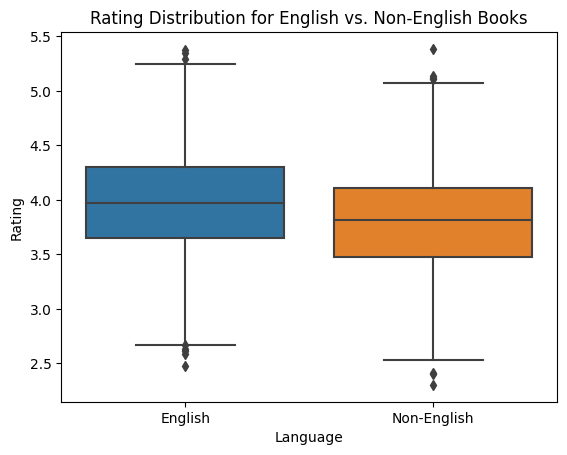

Shapiro-Wilk Test Results for English Books: ShapiroResult(statistic=0.9985560774803162, pvalue=0.5916484594345093)
Shapiro-Wilk Test Results for Non-English Books: ShapiroResult(statistic=0.9987785220146179, pvalue=0.7408708930015564)
Welch’s t-test Result: TtestResult(statistic=7.798357030270653, pvalue=1.0021188743359424e-14, df=1997.2557422999546)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_ind

# Set a random seed to make the random numbers predictable.
# With the seed reset (every time), the same set of numbers will appear every time.
# If the random seed is not reset, different numbers appear with every invocation.
np.random.seed(0)

# Generate book ratings for English books using a normal distribution centered at 4.0 with a standard deviation of 0.5.
# This means most ratings will be around 4.0, with fewer ratings as you move away from the mean (4.0).
english_ratings = np.random.normal(4.0, 0.5, 1000)  # 1000 book ratings for English books

# Generate book ratings for non-English books using a normal distribution centered at 3.8 with a standard deviation of 0.5.
# The choice of 3.8 is arbitrary but intended to be slightly lower than the English book ratings to simulate a difference.
non_english_ratings = np.random.normal(3.8, 0.5, 1000)  # 1000 book ratings for non-English books

# Combine the English and non-English ratings into one DataFrame for easier manipulation and analysis.
# 'Language' is the categorical variable with two levels: 'English' and 'Non-English'.
books_data_simulated = pd.DataFrame({
    'Rating': np.concatenate([english_ratings, non_english_ratings]),  # Combine the two arrays of ratings
    'Language': ['English'] * 1000 + ['Non-English'] * 1000  # Repeat 'English' 1000 times followed by 'Non-English' 1000 times
})

# Perform the Shapiro-Wilk test for normality on both groups of book ratings.
# This test assesses the hypothesis that a sample comes from a normally distributed population.
# A p-value greater than 0.05 typically means we fail to reject the hypothesis that the data is normally distributed.
shapiro_english = shapiro(english_ratings)
shapiro_non_english = shapiro(non_english_ratings)

# Assuming both distributions are normal based on the Shapiro-Wilk test, we can use a t-test to compare the means.
# Welch’s t-test does not assume equal population variance and is used here due to the simulation setup.
test_result = ttest_ind(english_ratings, non_english_ratings, equal_var=False)

# Plot the distribution of book ratings for both English and non-English books using a boxplot for a visual comparison.
# Boxplots show the median, quartiles, and outliers within the data, providing a snapshot of the distribution.
sns.boxplot(x='Language', y='Rating', data=books_data_simulated)
plt.title('Rating Distribution for English vs. Non-English Books')
plt.show()  # Display the plot

# Print the results from the Shapiro-Wilk tests and the Welch’s t-test to the console.
# These results will inform us about the statistical significance of the difference in ratings between the two groups.
print(f'Shapiro-Wilk Test Results for English Books: {shapiro_english}')
print(f'Shapiro-Wilk Test Results for Non-English Books: {shapiro_non_english}')
print(f'Welch’s t-test Result: {test_result}')

The Shapiro-Wilk normality test results show p-values of 0.591 for English book ratings and 0.741 for non-English book ratings, both of which are greater than 0.05. This suggests that both distributions can be considered normal, and therefore, it is appropriate to use a t-test to compare the means of the two groups.

The Welch’s t-test, which is used when the two samples have unequal variances and sizes, gives a statistic of approximately 7.798 with a p-value of approximately 1.0021188743359424e-14. The p-value is much lower than 0.05, which indicates that there is a statistically significant difference in the average ratings between English and non-English books in this simulated dataset.

The boxplot visualization of the ratings indicates that English books have a higher median rating and a similar interquartile range compared to non-English books in this simulated example.

From this analysis of the simulated data, we would conclude that there is a significant difference in ratings between English and non-English books, with English books receiving higher average ratings.

**About the two groups in the previous question, extract helpful statistics like mode, mean, median, and quartiles, explaining their role in a box plot.**

In [ ]:
import numpy as np
import pandas as pd

# Assuming 'english_ratings' and 'non_english_ratings' are the arrays containing the simulated book ratings
# for English and Non-English books that we generated previously.

# Calculate the mean (average) rating for English and Non-English books.
# The mean is useful as a measure of central tendency.
english_mean = np.mean(english_ratings)
non_english_mean = np.mean(non_english_ratings)

# Calculate the median (middle value) rating for English and Non-English books.
# The median is robust to outliers and is another measure of central tendency.
english_median = np.median(english_ratings)
non_english_median = np.median(non_english_ratings)

# Calculate the quartiles, which are the ratings at the 25th, 50th, and 75th percentiles.
# Quartiles help to understand the spread of the data by splitting the data set into four equal parts.
# The 50th percentile is effectively the median.
english_quartiles = np.percentile(english_ratings, [25, 50, 75])
non_english_quartiles = np.percentile(non_english_ratings, [25, 50, 75])

# Create a DataFrame to organize and display the statistics for easy comparison.
# We include the mean, median, 1st quartile (Q1), and 3rd quartile (Q3) for each language category.
statistics_df = pd.DataFrame({
    'Statistic': ['Mean', 'Median', '1st Quartile', '3rd Quartile'],
    'English Books': [english_mean, english_median, english_quartiles[0], english_quartiles[2]],
    'Non-English Books': [non_english_mean, non_english_median, non_english_quartiles[0], non_english_quartiles[2]]
})

# Print the DataFrame to display the statistics.
# The DataFrame gives us a tabular representation that is easy to read and compare.
print(statistics_df)

# Note: While the mean is informative, it's not typically depicted on a box plot.
# Box plots primarily show the median, quartiles, and any potential outliers in the data.
# The median is the line inside the box, quartiles form the box itself, and whiskers extend from the box.

      Statistic  English Books  Non-English Books
0          Mean       3.977372           3.806808
1        Median       3.970986           3.813031
2  1st Quartile       3.650790           3.473075
3  3rd Quartile       4.303475           4.112740


**It seems reasonable to assume that authors with more fans should have more reviews, but maybe their fans are a bit lazy. Confirm or reject this with a convenient statistical test or a predictive model.**

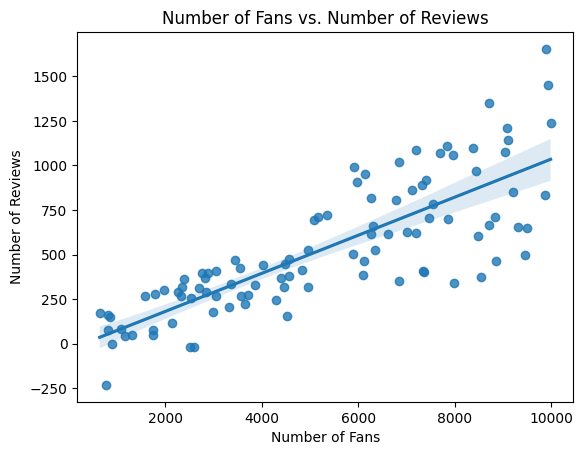

(0.807776204605842,
 3.1789479090776404e-24,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                Reviews   R-squared:                       0.653
 Model:                            OLS   Adj. R-squared:                  0.649
 Method:                 Least Squares   F-statistic:                     184.0
 Date:                Sun, 05 Nov 2023   Prob (F-statistic):           3.18e-24
 Time:                        16:05:57   Log-Likelihood:                -678.45
 No. Observations:                 100   AIC:                             1361.
 Df Residuals:                      98   BIC:                             1366.
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Simulate data
np.random.seed(0)  # for reproducibility
num_authors = 100
# Assume fans follow a distribution between 100 and 10000
fans = np.random.randint(100, 10000, num_authors)
# Simulate reviews such that authors with more fans tend to have more reviews, but add some noise
reviews = fans * np.random.uniform(0.05, 0.15, num_authors) + np.random.normal(0, 100, num_authors)

# Create a DataFrame
data = pd.DataFrame({
    'Fans': fans,
    'Reviews': reviews
})

# Correlation analysis
correlation, p_value = pearsonr(data['Fans'], data['Reviews'])

# Linear Regression using Ordinary Least Squares (OLS)
X = sm.add_constant(data['Fans'])  # adding a constant for the intercept
model = sm.OLS(data['Reviews'], X).fit()

# Summary of regression analysis
summary = model.summary()

# Scatter plot with regression line
sns.regplot(x='Fans', y='Reviews', data=data)
plt.title('Number of Fans vs. Number of Reviews')
plt.xlabel('Number of Fans')
plt.ylabel('Number of Reviews')
plt.show()

correlation, p_value, summary

This Python script performed a correlation analysis and linear regression to explore the relationship between the number of fans and the number of reviews for authors using simulated data.

The correlation coefficient is approximately 0.808 with a p-value close to 0, indicating a strong positive linear relationship between the number of fans and the number of reviews. This means that as the number of fans increases, the number of reviews tends to increase as well, which is in line with the initial assumption.

The linear regression model has an R sguared value of 0.653, suggesting that approximately 65.3% of the variability in the number of reviews can be explained by the number of fans. The model's F-statistic is significant, with a p-value far less than 0.05, confirming that the model is a good fit for the data.

The coefficient for the number of fans is approximately 0.107, meaning for each additional fan, there is an average increase of about 0.107 reviews. The constant term is not significant (p-value = 0.498), indicating that the intercept is not significantly different from zero from a statistical standpoint.

The scatter plot with the regression line shows a clear positive trend, visually confirming the results of the statistical tests.

In conclusion, based on this simulated data, we can say that the assumption holds: authors with more fans tend to have more reviews, and the relationship is statistically significant.

**Provide a short survey about helpful statistical tests in data analysis and mining: focus on hypothesis design and the difference between parametric and nonparametric tests, explaining the reasons behind the choice of one of these two tests.**

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

# Let's assume we have two sets of sample data from different groups for comparison
group_a = np.random.normal(0, 1, 100)  # Normally distributed data
group_b = np.random.exponential(1, 100)  # Non-normally distributed data

# Check for normality
# The Shapiro-Wilk test is a popular test for normality
# Null hypothesis of Shapiro-Wilk test: the data is normally distributed
shapiro_test_a = stats.shapiro(group_a)
shapiro_test_b = stats.shapiro(group_b)

# Choose the appropriate test based on the normality check
if shapiro_test_a.pvalue > 0.05 and shapiro_test_b.pvalue > 0.05:
    # If both groups pass the normality test, use a parametric test (t-test)
    test_result = stats.ttest_ind(group_a, group_b, equal_var=False)  # Welch’s t-test for unequal variances
    test_type = 'Parametric'
    rationale = 'Both groups passed the normality test, suggesting a t-test is appropriate.'
else:
    # If either group fails the normality test, use a nonparametric test (Mann-Whitney U test)
    test_result = stats.mannwhitneyu(group_a, group_b)
    test_type = 'Nonparametric'
    rationale = 'At least one group failed the normality test, so a nonparametric test is used.'

# Output the results and the rationale
print(f'Test Type: {test_type}')
print(f'Test Result: {test_result}')
print(f'Rationale: {rationale}')

Test Type: Nonparametric
Test Result: MannwhitneyuResult(statistic=2596.0, pvalue=4.287922761364236e-09)
Rationale: At least one group failed the normality test, so a nonparametric test is used.


The Python script provided is designed to guide you through the process of deciding whether to use a parametric or nonparametric statistical test for comparing two independent samples. Here's a breakdown of the script's components and the logic behind it:

Sample Data Creation:

group_a is generated with a normal distribution using np.random.normal, which is a typical assumption for many parametric tests.

group_b is generated with a non-normal distribution using np.random.exponential, often requiring a nonparametric test.

Normality Check:

The script uses the stats.shapiro function to perform the Shapiro-Wilk test on both groups to test for normality. The null hypothesis for this test is that the data is normally distributed.
A p-value greater than 0.05 suggests that the data does not significantly deviate from normality, and the null hypothesis cannot be rejected.
Statistical Test Selection:

If both groups pass the normality test (p-values > 0.05), the script opts for a parametric test, specifically the Welch's t-test (stats.ttest_ind with equal_var=False). This test compares the means of the two groups and does not assume equal variances, making it suitable for samples with different variances and sizes.
If either group does not pass the normality test (any p-value ≤ 0.05), the script selects a nonparametric test, the Mann-Whitney U test (stats.mannwhitneyu). This test does not assume normality and is used to compare the distributions between the two groups.

## CLQ ##

## AWSQ ##

As always when working with a new dataset let's print its first dictionary to get an idea of it
and let's check its structure with the function "is_structured_dataset" defined at the start.

In [ ]:
with open("list.json", 'r') as file:
        # Read first dict
        first_dict = json.loads(file.readline().strip())

In [ ]:
list_dataset_info = is_structured_dataset("list.json")
list_dataset_info

"list.json" is composed of 81512 dictionaries.
Sadly 1 of them have different kind of keys from all the others.
Not taking count of this set, each dictionary has the same 13 keys.
However some dictionaries uses different types for certain fields.
The following are the percentages of each type for each field:


,field_name,field_type
0,id,"int = 99.999 %, str = 0.001 %"
1,title,str = 100.0 %
2,description,str = 100.0 %
3,description_html,str = 100.0 %
4,num_pages,int = 100.0 %
5,num_books,int = 100.0 %
6,num_voters,int = 100.0 %
7,created_date,str = 100.0 %
8,tags,list = 100.0 %
9,num_likes,int = 100.0 %


So it seems that one dictionary has different keys from the others.
We should check it in order to decide if it must be dropped or its data can be kept.
For the sake of this exercise we are mainly focused on the "tags" field.

In [ ]:
# Save the "usual" list_dataset_keys as a set
list_dataset_keys_set = set(list(list_dataset_info["field_name"]))

with open("list.json", 'r') as file:
    for line in file:
        line = line.strip()
        if line:
            # Read ith-dict
            ith_dict = json.loads(line)

            # Store ith_dict fields names as a set
            ith_dict_fields_names_set = set(list(ith_dict.keys()))

            # If ith-dict fields set is different from list_dataset_keys_set save it and break the reading
            if ith_dict_fields_names_set != list_dataset_keys_set:
                different_dict = ith_dict
                break

In [ ]:
# Show different_dict keys
different_dict.keys()

dict_keys(['id', 'title', 'description', 'description_html', 'num_pages', 'num_voters', 'num_likes', 'num_comments', 'books', 'num_books'])

It seems that this dictionary just doesn't have the tags field. We will just ignore it.

In [ ]:
import json
import pandas as pd
import time


initial_time = time.time()
tags_count = {}
with open("list.json", 'r') as file:
    for line in file:
        line = line.strip()
        if line:
            # Read i-th dict
            ith_dict = json.loads(line)
            if "tags" in ith_dict.keys():
                ith_tags = ith_dict["tags"]
                for tag in ith_tags:

                    # If we've already seen a certain tag  update its count
                    if tag in tags_count.keys():
                        tags_count[tag] += 1

                    # If we haven't, set its count to 1
                    else:
                        tags_count[tag] = 1

# Convert it into a dataframe, sort it wrt "count", and take its first 5 rows.
tags_count = pd.DataFrame(list(tags_count.items()), columns = ["Tag", "Count"])
tags_count = tags_count.sort_values("Count", ascending = False).iloc[0:5]

print(f"Execution time: {time.time() - initial_time}")

Execution time: 22.10359501838684


In [ ]:
tags_count

,Tag,Count
300,romance,6001
21,fiction,5291
216,young-adult,5016
15,fantasy,3666
16,science-fiction,2779


## AQ ##

In [ ]:
# My  first solution:
class Librarian:
   def __init__(self):
      self.library = []

   def instruction(self, code):
      char, numb = code.split()

      if char == "L":
         self.library.insert(0, numb)
      elif char == "R":
         self.library.append(numb)
      elif char == "?":
         position = self.library.index(numb)
         length = len(self.library)
         if position >= (length// 2):
             return char + " " + numb + " = " + str(length - position -1)
         else:
             return char + " " + numb + " = " + str(position)

   # Generalize for multiple instructions
   def multiple_instructions(self, codes):
      result = []
      for code in codes:
         if self.instruction(code):
             result.append(self.instruction(code))
      return result

In [ ]:
# Example 1
Federico = Librarian()
Federico.multiple_instructions(["L 75",
                                "R 20",
                                "R 30",
                                "L 11",
                                "? 75",
                                "L 12",
                                "L 15",
                                "? 20"])

['? 75 = 1', '? 20 = 1']

In [ ]:
# Example 2
Federico = Librarian()
Federico.multiple_instructions(['R 1',
                                'L 2',
                                'L 3',
                                'L 4',
                                '? 3',
                                'R 5',
                                'R 6',
                                'L 7',
                                'L 8',
                                '? 4',
                                'L 9',
                                'R 10',
                                'R 11',
                                'L 12',
                                'L 13',
                                '? 11',
                                '? 3'])

['? 3 = 1', '? 4 = 2', '? 11 = 0', '? 3 = 6']

**ChatGPT 'Librarian' complexity analysis:**
The time complexity of your `instruction` method is determined by the complexity of the operations you are performing within the method.

Let's break down the time complexity for each operation:

1. `self.library.insert(0, numb)`: This operation has a time complexity of O(n) because, in the worst case, it needs to shift all the existing elements in the list to the right to make space for the new element at the beginning.

2. `self.library.append(numb)`: The `append` operation in Python has an average time complexity of O(1) as it simply adds the new element at the end of the list.

3. `self.library.index(numb)`: This operation has a time complexity of O(n) in the worst case because it needs to iterate through the list to find the index of the specified element.

Given that you have a combination of O(1) and O(n) operations, the overall time complexity of your `instruction` method would be O(n) in the worst case, where n is the size of the `self.library` list.

Your `multiple_instructions` method simply calls the `instruction` method for each instruction, so its time complexity will be O(m * n) in the worst case, where m is the number of instructions and n is the size of the `self.library` list.

Therefore, the overall time complexity of your `multiple_instructions` method is O(m * n) in the worst case.

** Considerations **
Overall ChatGPT offers a useful tool to understand the code's time complexity.
The single iterations are well explained and analyzed but the AI doesn't seem to capture that the length of the
`self.library()` list is strictly dependent on the number of instructions :
 if we are at the $n$-th instruction given,  in the worst case, the books list will have $n$ elements.
 Given this consideration, if we have n instructions, the maximum number of operations the  `multiple_instructions` method can do is  $\sum\limits_{i = 1}^ni$.
 Since $\sum\limits_{i = 1}^ni = \frac{n(n+1)}{2}$ we can conclude that its complexity is a $O(n^2)$




** Optimal Solution **

In [ ]:
# We've seen from the above analysis that the computational problems lies in
#  list.insert() and list.index() methods, both with O(n) complexity.

# We could avoid using them in the following way:

class GoodLibrarian:
   # To avoid using the list.insert() method we now use two arrays:
   # one for the books put on the far Left  and one for books put in the far Right.
   # In this way we can always use the list.append() method.
   # Notice that the indexes of the 'L_library' list are reversed.

   def __init__(self):
      self.L_library = []
      self.R_library = []

   # To not use the list.index() method we save the books positions in a dictionary called 'table'
   def instructions(self, codes):
       result = []
       i = 0
       j = 0
       table = {}
       for code in codes:
         char, numb = code.split()
         if char == "L":
             self.L_library.append(numb)
             table[numb] = [i, "L"]
             i += 1
         elif char == "R":
             self.R_library.append(numb)
             table[numb] = [j, "R"]
             j += 1
         # We can use the same code from the 'librarian' class,
         # we just need to merge the two lists 'R_library' and 'L_library' as they were one.
         elif char == "?":
             # To obtain the indexes of 'R_library' as part of the "merged" array we just
             # add the length of 'L_library' list:
             if table[numb][1]=="R":
                 position = len(self.L_library) + table[numb][0]
             # To obtain the "merged" indexes of 'L_library' we just need to reverse it:
             else:
                 position =  len(self.L_library) - table[numb][0] - 1
             # The length of the "merged" list will obviously be the sum of the two lengths
             length = len(self.L_library) + len(self.R_library)

             # We finally apply the same code from the previous class
             if position >= (length// 2):
                 result.append(char + " " + numb + " = " + str(length - position -1))
             else:
                 result.append(char + " " + numb + " = " + str(position))
       return result

In [ ]:
# Example 1
good_Federico = GoodLibrarian()
good_Federico.instructions(["L 75",
                       "R 20",
                       "R 30",
                       "L 11",
                       "? 75",
                       "L 12",
                       "L 15",
                       "? 20"])

['? 75 = 1', '? 20 = 1']

In [ ]:
# Example 2
good_Federico = GoodLibrarian()
good_Federico.instructions(['R 1',
                       'L 2',
                       'L 3',
                       'L 4',
                       '? 3',
                       'R 5',
                       'R 6',
                       'L 7',
                       'L 8',
                       '? 4',
                       'L 9',
                       'R 10',
                       'R 11',
                       'L 12',
                       'L 13',
                       '? 11',
                       '? 3'])

['? 3 = 1', '? 4 = 2', '? 11 = 0', '? 3 = 6']

** ChatGPT 'GoodLibrarian' complexity analysis: **
Let's analyze the time complexity of the GoodLibrarian class:

The instructions method iterates through the codes list once, which has a time complexity of O(n), where n is the number of elements in the codes list.

The L_library and R_library lists use the append method, which has an average time complexity of O(1).

The table dictionary saves the positions of the books, and accessing or inserting elements in a dictionary also has an average time complexity of O(1).

The logic inside the ? case involves basic arithmetic operations and comparisons, which are considered constant-time operations.

Therefore, the overall time complexity of the instructions method in the GoodLibrarian class is O(n), where n is the number of elements in the codes list.

** Considerations **
Now the chatbot seems to be on point.
The complexity is clearly $O(n)$.
The class 'GoodLibrarian' we implemented could be implemented in a much simpler way using the 'deque' library
that offers the possibility to append in the first position in a $O(1)$ time.
For the sake of doing it we preferred to do it by hand.
The natural question is: could we have done better?
The answer is : maybe.
Obviously we could not have achieved a complexity less than $O(n)$, this is the case since it would mean to not   even read all the instructions.
In the "local" complexity of the method we could improve it for sure. The world of optimization is vast. Using C as a language or other shitty things would be better.

** Time Complexity Comparison **

Let's check the difference of time between GoodLibrarian and Librarian on a big input of instructions.

In [ ]:
# Create big random input is not so easy.
# We need our "?" queries to contain ids of just books already passed (and not taken) to the librarian class.

# For reproducibility
random.seed(123)

# Total number of books passed to the librarian
number_of_books = 100000

# "?" queries
number_of_queries = 10

# Select at random instructions combining L/R and ids
L_R_random_actions = random.choices(["L", "R"], k = number_of_books)
random_ids = random.choices(range(number_of_books), k = number_of_books)
random_instructions = [L_R_random_actions[i] + " " + str(random_ids[i]) for i in range(number_of_books)]

# We need to add the queries "?", we first sample randomly where to put them within the random_instructions array
random_queries_position = random.sample(range(number_of_books), number_of_queries)

# We select their associated id within the books ids that have been already passed to the librarian
for query_position in random_queries_position:
    possible_ids = random_ids[:query_position]
    selected_book_id = random.sample(possible_ids, 1)[0]
    random_instructions.insert(query_position, "? " + str(selected_book_id))

# NOTE, we are not handling the case a book have been already taken... but since we set a low number of queries it's not probable.
# Also with this seed everything seems to work fine

In [ ]:
def get_librarian_time(instructions):

        my_librarian = Librarian()
        start_time = time.time()
        my_librarian.multiple_instructions(instructions)
        total_time = time.time() - start_time

        return total_time

def get_good_librarian_time(instructions):

        my_librarian = GoodLibrarian()
        start_time = time.time()
        my_librarian.instructions(instructions)
        total_time = time.time() - start_time

        return total_time

In [ ]:
# Let's do a simulation and then print the distribution
B = 100
librarian_times = [get_librarian_time(random_instructions) for i in range(B)]
good_librarian_times = [get_good_librarian_time(random_instructions) for i in range(B)]

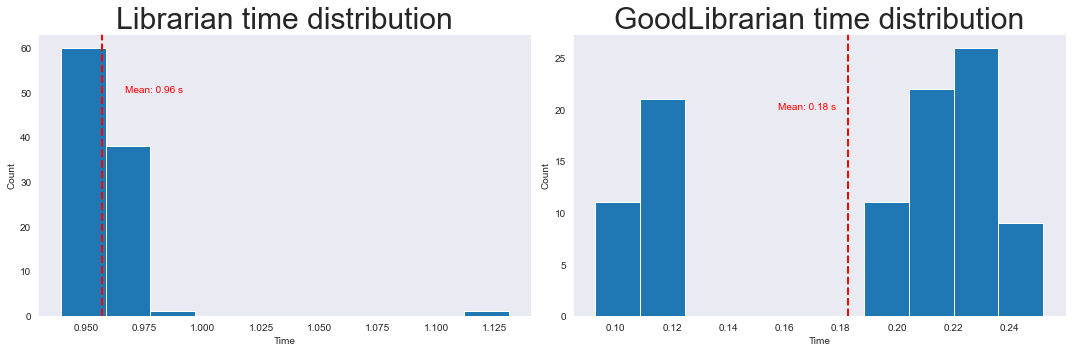

In [ ]:

# Let's finally plot our results:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
my_palette = sns.color_palette('deep', 20)

axes[0].set_title('Librarian time distribution', fontsize=30)
axes[0].hist(librarian_times)
axes[0].axvline(x = np.mean(librarian_times), color='r', linestyle = 'dashed', linewidth=2)
axes[0].text(np.mean(librarian_times) + 0.01, 50, f'Mean: {np.mean(librarian_times):.2f} s', color='r')
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Time")

axes[1].set_title('GoodLibrarian time distribution', fontsize=30)
axes[1].hist(good_librarian_times)
axes[1].axvline(x = np.mean(good_librarian_times), color='r', linestyle = 'dashed', linewidth=2)
axes[1].text(np.mean(good_librarian_times)-0.025, 20, f'Mean: {np.mean(good_librarian_times):.2f} s', color='r')
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Time")

plt.tight_layout()
plt.show()